<a href="https://colab.research.google.com/github/RuCoRaMi/thelastdance/blob/main/AD_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Import Library

In [39]:
import os
import numpy as np
import pandas as pd

from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from PIL import Image

import warnings
warnings.filterwarnings('ignore')

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

from helper_functions import plot_loss_curves

--2024-08-29 01:32:48--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2024-08-29 01:32:49 (11.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



# 2. Load Data

In [3]:
#download data
!gdown --id 1AQLWiTNzwrIQQRjmpiylho9uAHRBmqdG -O MRI.zip

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1AQLWiTNzwrIQQRjmpiylho9uAHRBmqdG
From (redirected): https://drive.google.com/uc?id=1AQLWiTNzwrIQQRjmpiylho9uAHRBmqdG&confirm=t&uuid=af29de14-c747-4b8e-9d24-cb263db8ee43
To: /content/MRI.zip
100% 397M/397M [00:07<00:00, 52.9MB/s]


In [4]:
#unzip data
!unzip -q '/content/MRI.zip' -d 'MRI'

In [5]:
#Defining
SAMPLE_PER_CATEGORY = 200
#SEED = 42
WIDTH = 224
HEIGHT = 224
DEPTH = 3
INPUT_SHAPE = (WIDTH, HEIGHT, DEPTH)

data_dir = '/content/MRI/data'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'val')


# 3. Defining Categories

In [6]:
CATEGORIES = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
NUM_CATEGORIES = len(CATEGORIES)
NUM_CATEGORIES

4

Calculating the number of images in each categories

In [7]:
for category in CATEGORIES:
    print('{} {} images'.format(category, len(os.listdir(os.path.join(train_dir, category)))))

MildDemented 8960 images
ModerateDemented 6464 images
NonDemented 9600 images
VeryMildDemented 8960 images


In [8]:
for category in CATEGORIES:
    print('{} {} images'.format(category, len(os.listdir(os.path.join(test_dir, category)))))

MildDemented 896 images
ModerateDemented 64 images
NonDemented 3200 images
VeryMildDemented 2240 images


# 4. Creating Train and Validation DataFrame

In [9]:
train = []
for category_id, category in enumerate(CATEGORIES):
    for file in os.listdir(os.path.join(train_dir, category)):
        train.append(['train/{}/{}'.format(category, file), category_id, category])
train = pd.DataFrame(train, columns=['file', 'category_id', 'category'])
train.shape

(33984, 3)

In [10]:
train = train.sample(frac=1)
X = train.drop(columns = 'category_id')
y = train['category_id']

In [18]:
x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=4)

In [19]:
train = pd.concat([x_train, y_train], axis=1)
validation = pd.concat([x_valid, y_valid], axis=1)

In [20]:
train = train.reset_index()
train = train.drop(columns = 'index')
validation = validation.reset_index()
validation = validation.drop(columns = 'index')
print(train.shape)
print(validation.shape)

(25488, 3)
(8496, 3)


In [21]:
train.head()

,file,category,category_id
0,train/NonDemented/121ecd6a-e519-4f9f-bd61-dce3...,NonDemented,2
1,train/VeryMildDemented/deecd696-909f-4a86-9e90...,VeryMildDemented,3
2,train/NonDemented/875df9eb-2e77-4b29-b3f8-f5eb...,NonDemented,2
3,train/VeryMildDemented/9b9c22f5-65d2-42e8-8cac...,VeryMildDemented,3
4,train/NonDemented/8466d5f3-2d3d-44b3-bdfd-76a6...,NonDemented,2


In [22]:
validation.head()

,file,category,category_id
0,train/VeryMildDemented/fd2ce078-a1b0-4af3-8224...,VeryMildDemented,3
1,train/MildDemented/49252cf2-27f3-45c1-82d4-be2...,MildDemented,0
2,train/ModerateDemented/0ce35616-5403-46a1-8f6c...,ModerateDemented,1
3,train/ModerateDemented/a8620392-9a83-4691-b13f...,ModerateDemented,1
4,train/ModerateDemented/a826e29a-01e8-4068-995c...,ModerateDemented,1


# 5. Creating Test DataFrame

In [23]:
test = []
for category_id, category in enumerate(CATEGORIES):
    for file in os.listdir(os.path.join(test_dir, category)):
        test.append(['val/{}/{}'.format(category, file), category_id, category])
test = pd.DataFrame(test, columns=['file', 'category_id', 'category'])
test.shape

(6400, 3)

In [24]:
test.head()

,file,category_id,category
0,val/MildDemented/mildDem297.jpg,0,MildDemented
1,val/MildDemented/mildDem592.jpg,0,MildDemented
2,val/MildDemented/mildDem311.jpg,0,MildDemented
3,val/MildDemented/mildDem553.jpg,0,MildDemented
4,val/MildDemented/mildDem288.jpg,0,MildDemented


# 6. Demonstrating Example Images

In [25]:
def read_img(filepath, size):
    img = image.load_img(os.path.join(data_dir, filepath), target_size=size)
    img = image.img_to_array(img)
    return img

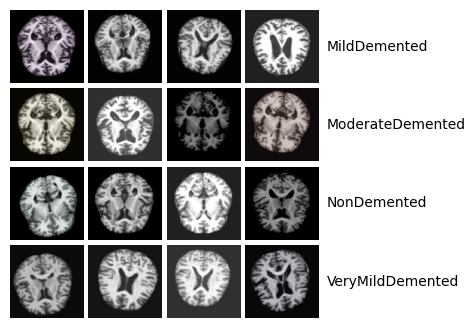

In [26]:
fig = plt.figure(1, figsize=(NUM_CATEGORIES, NUM_CATEGORIES))
grid = ImageGrid(fig, 111, nrows_ncols=(NUM_CATEGORIES, NUM_CATEGORIES), axes_pad=0.05)

i=0
for category_id, category in enumerate(CATEGORIES):
    for filepath in train[train['category'] == category]['file'].values[:NUM_CATEGORIES]:
        ax = grid[i]
        img = read_img(filepath, (WIDTH, HEIGHT))
        ax.imshow(img / 255.)
        ax.axis('off')
        if i % NUM_CATEGORIES == NUM_CATEGORIES - 1:
            ax.text(250, 112, filepath.split('/')[1], verticalalignment='center')
        i+=1

plt.show();

# 7. Keras ImageDataGenerator

In [29]:
datagen_train = ImageDataGenerator(rescale=1./255)
train_generator = datagen_train.flow_from_dataframe(dataframe=train,
                                                  directory="/content/MRI/data",
                                                  x_col="file",
                                                  y_col="category",
                                                  batch_size=64,
                                                  shuffle=True,
                                                  class_mode="categorical",
                                                  target_size=(HEIGHT, WIDTH));

validation_generator = datagen_train.flow_from_dataframe(dataframe=validation,
                                                  directory="/content/MRI/data",
                                                  x_col="file",
                                                  y_col="category",
                                                  batch_size=64,
                                                  shuffle=True,
                                                  class_mode="categorical",
                                                  target_size=(HEIGHT, WIDTH));

Found 25488 validated image filenames belonging to 4 classes.
Found 8496 validated image filenames belonging to 4 classes.


In [30]:
datagen_test = ImageDataGenerator(rescale=1./255)
test_generator = datagen_test.flow_from_dataframe(dataframe=test,
                                                  directory="/content/MRI/data",
                                                  x_col="file",
                                                  y_col="category",
                                                  batch_size=64,
                                                  shuffle=False,
                                                  class_mode="categorical",
                                                  target_size=(HEIGHT, WIDTH));

Found 6400 validated image filenames belonging to 4 classes.


# 8. Early Stopping

In [32]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# 9. Creating Model Based on ResNet152V2

In [40]:
#Building Model
def create_model():

    resnet_model = tf.keras.applications.resnet_v2.ResNet152V2(
        weights='imagenet',
        include_top = False,
        input_shape = (224, 224, 3)
    )

    for layers in resnet_model.layers[:100]:
        layers.trainable = False #freeze first number of layers of resnet
    for layers in resnet_model.layers[100:]:
        layers.trainable = True #unfreeze layers start from indexed number

    x = resnet_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    #x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    # output layer
    predictions = tf.keras.layers.Dense(4, activation='softmax')(x)

    res_model = tf.keras.Model(inputs=resnet_model.input, outputs=predictions)

    # Compiling the model
    res_model.compile(loss='categorical_crossentropy', optimizer=Adamax(learning_rate = 0.001), metrics=['accuracy'])
    return res_model

In [41]:
res_model = create_model()

In [42]:
res_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_conv[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_bn    │ (None, 56, 56, 64)     │            256 │ pool1_pool[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_relu  │ (None, 56, 56, 64)     │              0 │ conv2_block1_preact_b… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,096 │ conv2_block1_preact_r… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_pad        │ (None, 58, 58, 64)     │              0 │ conv2_block1_1_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,864 │ conv2_block1_2_pad[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv  

 Total params: 61,119,364 (233.15 MB)

 Trainable params: 59,182,212 (225.76 MB)

 Non-trainable params: 1,937,152 (7.39 MB)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.173136 to fit



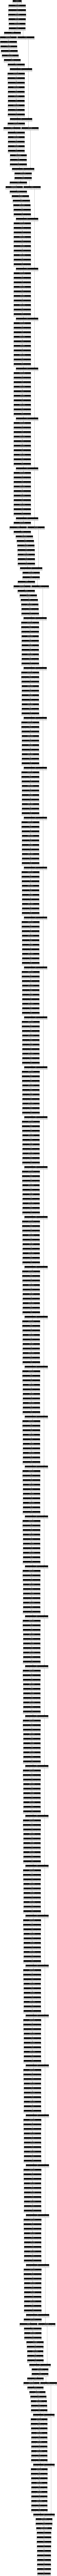

In [43]:
# visualize model architecture
tf.keras.utils.plot_model(res_model, show_shapes=True)

# 10. Training the Model

In [44]:
history = res_model.fit(train_generator,
                    epochs=100,
                    steps_per_epoch=100,
                    validation_data=validation_generator,
                    callbacks=[early_stopping],
                    batch_size=48)

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 321s 2s/step - accuracy: 0.3946 - loss: 1.2135 - val_accuracy: 0.6430 - val_loss: 1.4871
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - accuracy: 0.6945 - loss: 0.6753 - val_accuracy: 0.6946 - val_loss: 1.2687
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - accuracy: 0.7872 - loss: 0.5045 - val_accuracy: 0.7359 - val_loss: 0.6068
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 184s 2s/step - accuracy: 0.8374 - loss: 0.4061 - val_accuracy: 0.8192 - val_loss: 0.5453
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 163s 1s/step - accuracy: 0.8915 - loss: 0.2850 - val_accuracy: 0.8280 - val_loss: 0.4278
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 184s 2s/step - accuracy: 0.9090 - loss: 0.2463 - val_accuracy: 0.7973 - val_loss: 0.6893
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 149s 1s/step - accuracy: 0.9359 - loss: 0.1888 - val_accuracy: 0.9153 - val_loss: 0.2510
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 147s 1s/step - accuracy: 0.9444 - loss: 0.1615 - 

Plotting Model History

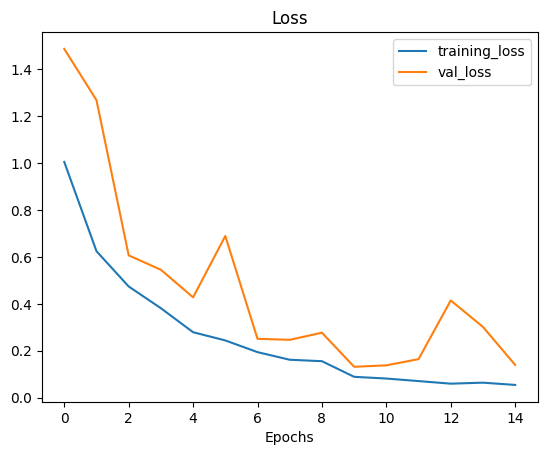

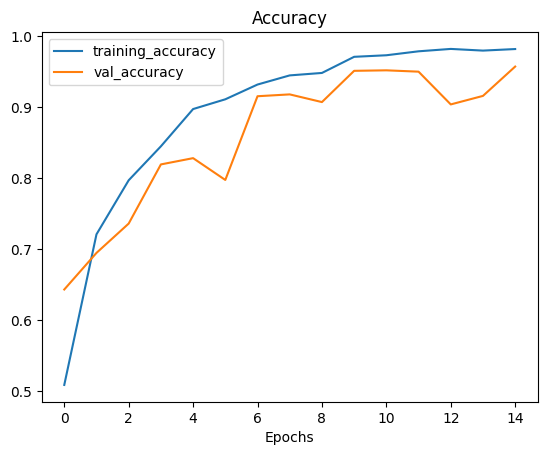

In [45]:
plot_loss_curves(history)

# 10. Evaluation

In [46]:
valid_loss, valid_accuracy = res_model.evaluate(validation_generator)

print(f'\nVTraining loss: {valid_loss:.2f}')
print(f'Training Accuracy: {valid_accuracy*100:.2f} %')

133/133 ━━━━━━━━━━━━━━━━━━━━ 45s 340ms/step - accuracy: 0.9523 - loss: 0.1245

VTraining loss: 0.13
Training Accuracy: 95.10 %


In [47]:
loss, accuracy = res_model.evaluate(test_generator)

print(f'\nTest loss: {loss:.2f} ')
print(f'Test Accuracy: {accuracy*100:.2f} %')

100/100 ━━━━━━━━━━━━━━━━━━━━ 34s 343ms/step - accuracy: 0.9848 - loss: 0.0396

Test loss: 0.08 
Test Accuracy: 97.09 %


In [48]:
y_predict = res_model.predict(test_generator)
prediction = np.argmax(y_predict,axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
prediction = [labels[k] for k in prediction]

y_test = list(test.category)

report = classification_report(y_test, prediction, output_dict=True)
df = pd.DataFrame(report).transpose()
df

100/100 ━━━━━━━━━━━━━━━━━━━━ 40s 320ms/step


,precision,recall,f1-score,support
MildDemented,0.994388,0.988839,0.991606,896.000000
ModerateDemented,0.955224,1.000000,0.977099,64.000000
NonDemented,0.959320,0.987500,0.973206,3200.000000
VeryMildDemented,0.979516,0.939286,0.958979,2240.000000
accuracy,0.970938,0.970938,0.970938,0.970938
macro avg,0.972112,0.978906,0.975223,6400.000000
weighted avg,0.971257,0.970938,0.970842,6400.000000


from matplotlib import pyplot as plt
df['precision'].plot(kind='hist', bins=20, title='precision')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df['recall'].plot(kind='hist', bins=20, title='recall')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df['f1-score'].plot(kind='hist', bins=20, title='f1-score')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df['support'].plot(kind='hist', bins=20, title='support')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='precision', y='recall', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='recall', y='f1-score', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='f1-score', y='support', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df['precision'].plot(kind='line', figsize=(8, 4), title='precision')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df['recall'].plot(kind='line', figsize=(8, 4), title='recall')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df['f1-score'].plot(kind='line', figsize=(8, 4), title='f1-score')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df['support'].plot(kind='line', figsize=(8, 4), title='support')
plt.gca().spines[['top', 'right']].set_visible(False)

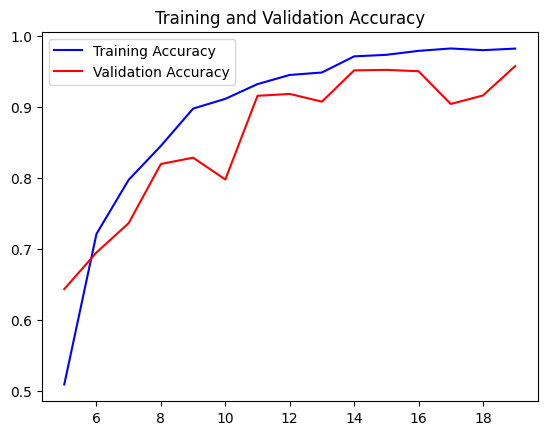

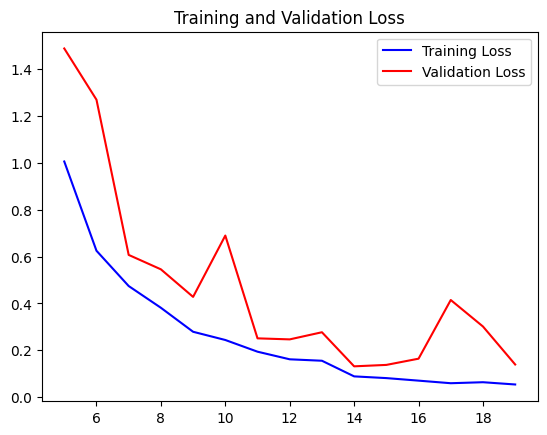

In [49]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(5, len(acc)+5)

#Plotting training and validation accuracy graph
plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

#Plotting training and validation loss graph
plt.figure()
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [50]:
#Test data confusion matrix
def create_classification_report(model_name):
  y_pred = model_name.predict(test_generator)
  y_pred = np.argmax(y_pred, axis=1)
  y_true = test_generator.classes

  cm = confusion_matrix(y_true, y_pred)
  class_names = list(test_generator.class_indices.keys())

  plt.figure(figsize=(8, 6), dpi=100)
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.title('Confusion Matrix')
  #plt.savefig('confusion_matrix.png')
  plt.show()

  report = classification_report(y_true, y_pred, target_names=class_names)
  print(report)

100/100 ━━━━━━━━━━━━━━━━━━━━ 32s 322ms/step


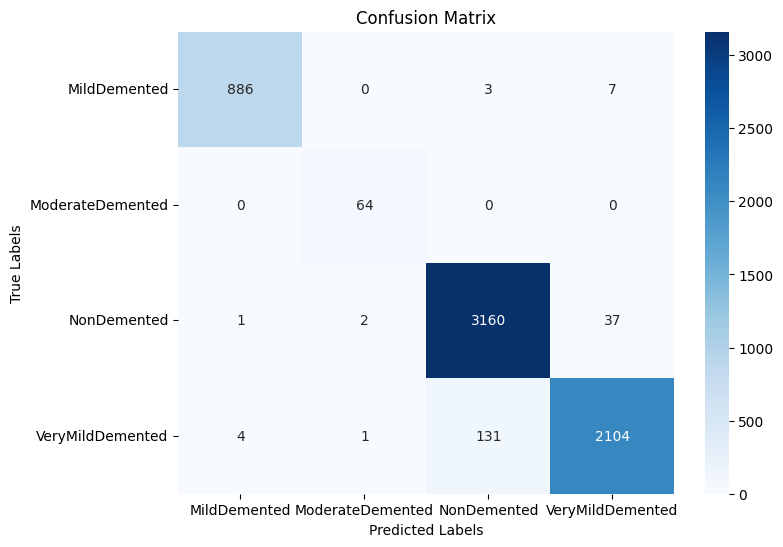

                  precision    recall  f1-score   support

    MildDemented       0.99      0.99      0.99       896
ModerateDemented       0.96      1.00      0.98        64
     NonDemented       0.96      0.99      0.97      3200
VeryMildDemented       0.98      0.94      0.96      2240

        accuracy                           0.97      6400
       macro avg       0.97      0.98      0.98      6400
    weighted avg       0.97      0.97      0.97      6400



In [51]:
create_classification_report(res_model)